In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Задание 1

Примените метод SVM (например, из библиотеки sklearn) для датасета blobs2.
Визуализируйте результат (разбиение плоскости и опорные вектора) при разных
вариантах ядер (линейное; полиномиальное степеней 2,3,5; RBF).

In [2]:
def fit_and_plot(X, y, kernel, degree=0, C=1):
    model = SVC(kernel=kernel, C=C, degree=degree, gamma='auto')
    model.fit(X, y)
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=200,
               linewidth=1, facecolors='none', edgecolors='k')
    if degree == 0:
        plt.title(f"SVM, kernel={kernel}, C={C}")
    else:
        plt.title(f"SVM, kernel={kernel}, degree={degree}, C={C}")
    plt.show()

In [3]:
df = pd.read_csv('blobs2.csv')
X = df[df.columns.difference(['label'])].values
y = df.label

Linear kernel

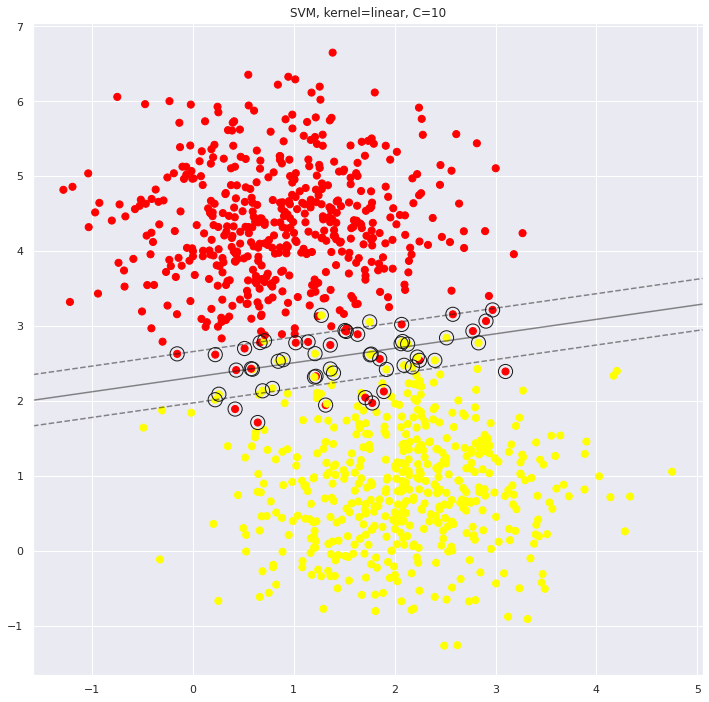

In [4]:
fit_and_plot(X, y, 'linear', C=10)

Polynomial kernel, degree 2

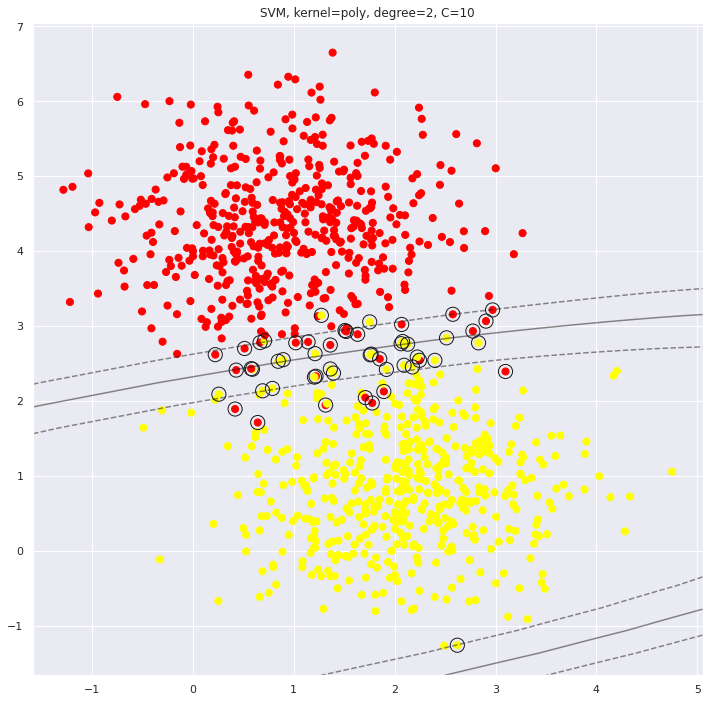

In [5]:
fit_and_plot(X, y, 'poly', degree=2, C=10)

Polynomial kernel, degree 3

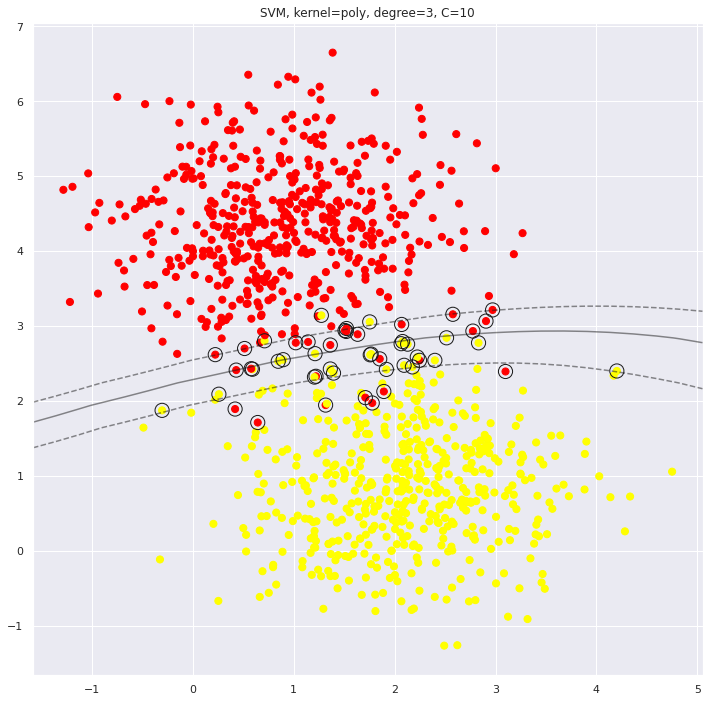

In [6]:
fit_and_plot(X, y, 'poly', degree=3, C=10)

Polynomial kernel, degree 5

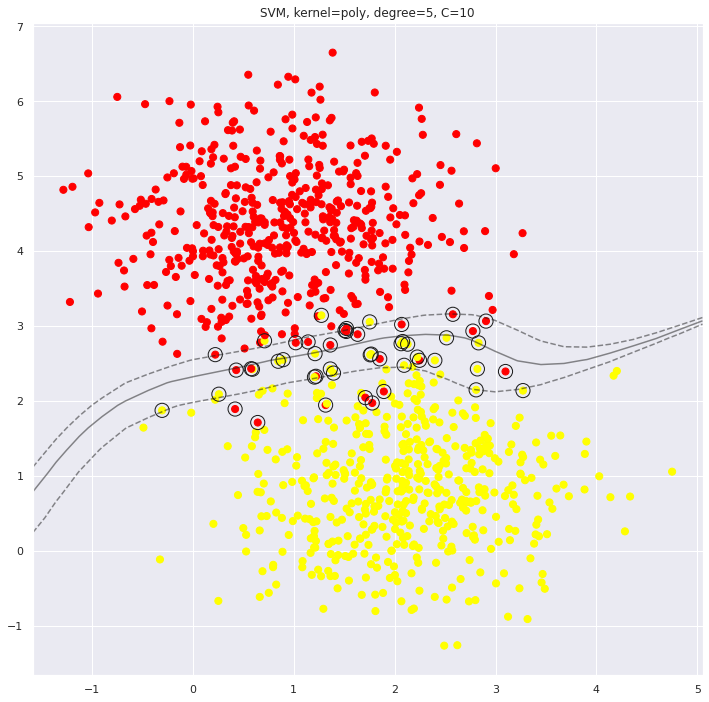

In [7]:
fit_and_plot(X, y, 'poly', degree=5, C=10)

RBF kernel

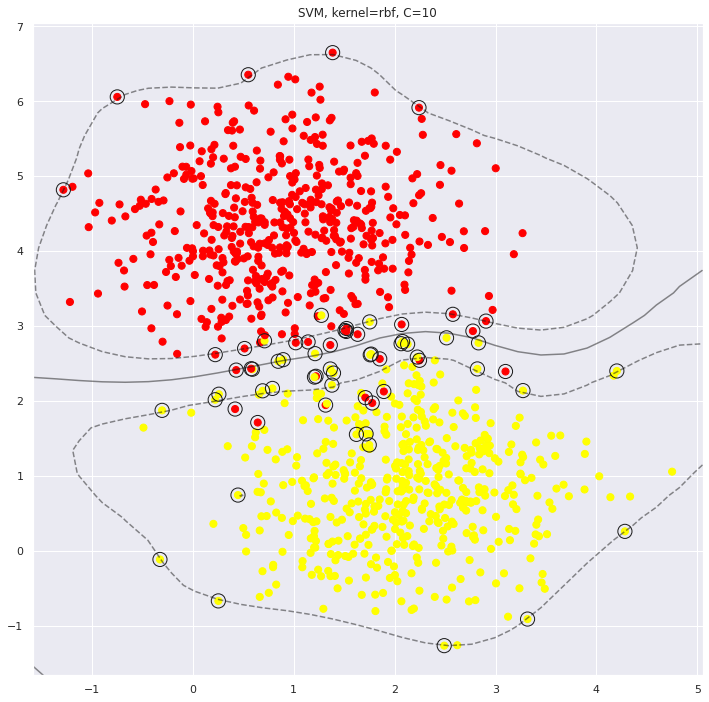

In [8]:
fit_and_plot(X, y, 'rbf', C=10)

### Задание 2

Примените метод SVM на датасетах cancer и spam, разбитый предварительно на
train (80%) и validate (20%). Сравните время работы SVM и Random Forest при близкой
точности.

**Spam dataset**

In [9]:
spam_df = pd.read_csv('spam.csv')
X = spam_df[spam_df.columns.difference(['label'])].values
y = spam_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Select best SVM parameters

In [10]:
parameters = {'kernel':['rbf'], 'C':[0.1, 1, 1e2, 1e3, 1e4, 1e5, 1e6],
              'gamma':[1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', verbose=2, n_jobs=8)
clf.fit(X_test, y_test)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.1, 1, 100.0, 1000.0, 10000.0, 100000.0,
                               1000000.0],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                   1e-07],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [11]:
print(clf.best_params_)

{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


Compare RandomForest and SVM

In [12]:
rf = RandomForestClassifier(random_state=42)

rf_train_start = time()
rf.fit(X_train, y_train)
rf_train_stop = time()

rf_test_start = time()
rf_predictions = rf.predict(X_test)
rf_test_stop = time()

svm = SVC(kernel='rbf', gamma=0.001, C=100, random_state=42)
svm_train_start = time()
svm.fit(X_train, y_train)
svm_train_stop = time()

svm_test_start = time()
svm_predictions = svm.predict(X_test)
svm_test_stop = time()

In [13]:
rf_acc = np.round(accuracy_score(rf_predictions, y_test), decimals=5)
svm_acc = np.round(accuracy_score(svm_predictions, y_test), decimals=5)
print(f"RandomForest accuracy: {rf_acc}, SVM accuracy: {svm_acc}")
print()
print("----Train time----")
rf_train_time = np.round(rf_train_stop-rf_train_start, decimals=3)
svm_train_time = np.round(svm_train_stop-svm_train_start, decimals=4)
print(f"RandomForest: {rf_train_time}s, SVM: {svm_train_time}s")
print()
print("----Test time----")
rf_test_time = np.round(rf_test_stop-rf_test_start, decimals=3)
svm_test_time = np.round(svm_test_stop-svm_test_start, decimals=4)
print(f"RandomForest: {rf_test_time}s, SVM: {svm_test_time}s")

RandomForest accuracy: 0.95548, SVM accuracy: 0.94354

----Train time----
RandomForest: 0.622s, SVM: 0.2889s

----Test time----
RandomForest: 0.022s, SVM: 0.0585s


**Cancer dataset**

In [14]:
cancer_df = pd.read_csv('cancer.csv')
cancer_df['int_label'] = cancer_df.label.map({'M':1, 'B':0})
cancer_df['label'] = cancer_df.int_label
cancer_df.drop('int_label', axis=1, inplace=True)
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Select best SVM parameters

In [15]:
parameters = {'kernel':['rbf'], 'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 1e-2, 1e-3, 1e-4]}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', verbose=2, n_jobs=8)
clf.fit(X_test, y_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [16]:
print(clf.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


Compare RandomForest and SVM

In [17]:
rf = RandomForestClassifier(random_state=42)

rf_train_start = time()
rf.fit(X_train, y_train)
rf_train_stop = time()

rf_test_start = time()
rf_predictions = rf.predict(X_test)
rf_test_stop = time()

svm = SVC(kernel='rbf', gamma=0.01, C=1, random_state=42)
svm_train_start = time()
svm.fit(X_train, y_train)
svm_train_stop = time()

svm_test_start = time()
svm_predictions = svm.predict(X_test)
svm_test_stop = time()

In [48]:
rf_acc = np.round(accuracy_score(rf_predictions, y_test), decimals=5)
svm_acc = np.round(accuracy_score(svm_predictions, y_test), decimals=5)
print(f"RandomForest accuracy: {rf_acc}, SVM accuracy: {svm_acc}")
print()
print("----Train time----")
rf_train_time = np.round(rf_train_stop-rf_train_start, decimals=3)
svm_train_time = np.round(svm_train_stop-svm_train_start, decimals=4)
print(f"RandomForest: {rf_train_time}s, SVM: {svm_train_time}s")
print()
print("----Test time----")
rf_test_time = np.round(rf_test_stop-rf_test_start, decimals=3)
svm_test_time = np.round(svm_test_stop-svm_test_start, decimals=4)
print(f"RandomForest: {rf_test_time}s, SVM: {svm_test_time}s")

RandomForest accuracy: 0.96491, SVM accuracy: 0.96491

----Train time----
RandomForest: 0.016s, SVM: 0.0066s

----Test time----
RandomForest: 0.001s, SVM: 0.0008s
